<a href="https://colab.research.google.com/github/noallynoclan/colab/blob/master/201230_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
! pip install torchsummary -q

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from datetime import datetime
from matplotlib import pyplot as plt
from time import time
from torch.utils.data import DataLoader
from torchsummary import summary

torch.__version__

'1.7.0+cu101'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
! pip install wandb -qqq
import wandb
wandb.login()

PROJECT = 'INCEPTION_{}'.format(datetime.now().strftime('%y%m%d'))
PROJECT

     |████████████████████████████████| 1.8MB 9.1MB/s 
     |████████████████████████████████| 163kB 15.1MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 133kB 22.8MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


'INCEPTION_201230'

In [134]:
batch_size = 64

train_dataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [136]:
def accuracy(model, data_loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x).argmax(1)
            num_correct += (y == y_pred).sum()
            num_samples += y.size(0)
    acc = num_correct / num_samples
    return acc

def train(run_name, model, data_loader, num_epochs=2, learning_rate=1e-3):
    name = '{}_{}'.format(run_name, datetime.now().strftime('%H%M%S'))
    wandb.init(project=PROJECT, name=name)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fun = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        start_time = time()
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            scores = model(x)
            loss = loss_fun(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            wandb.log({'loss': loss})
        print(f'epoch {epoch}, {time() - start_time:.1f}s: {accuracy(model, data_loader):.1%}')

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x): # [N, in_channels, *size]
        x = self.conv(x) # [N, out_channels, *size]
        x = self.batchnorm(x) # [N, ]
        return self.relu(x)
    
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1_pool):
        super(InceptionBlock, self).__init__()
        self.branch1 = ConvBlock(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, red_3x3, kernel_size=1),
            ConvBlock(red_3x3, out_3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, red_5x5, kernel_size=1),
            ConvBlock(red_5x5, out_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_1x1_pool, kernel_size=1)
        )
        
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
    
class GoogLeNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10000):
        super(GoogLeNet, self).__init__()
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        self.to(device)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

In [154]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(ConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

    def get_shape(self, in_shape):
        batches, in_channels, *size = in_shape
        size = (np.array(size) + 2 * self.padding - self.kernel_size) // self.stride + 1
        num_params = self.out_channels * (self.in_channels * self.kernel_size ** 2 + 3)
        return [batches, self.out_channels, *size], num_params

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionBlock, self).__init__()
        self.in_channels = in_channels 
        self.out_channels = out_channels
        self.branch1 = ConvBlock(in_channels, out_channels // 4, kernel_size=1) 
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, out_channels // 2, kernel_size=1), 
            ConvBlock(out_channels // 2, out_channels // 2, kernel_size=3, padding=1) 
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, out_channels // 16, kernel_size=1), 
            ConvBlock(out_channels // 16, out_channels // 8, kernel_size=5, padding=2), 
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_channels // 8, kernel_size=1)
        )
        
    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)

    def get_shape(self, in_shape):
        batches, in_channels, *size = in_shape
        num_params = [
            self.out_channels // 4 * (self.in_channels * 1 ** 2 + 3),
            sum([
                self.out_channels // 2 * (self.in_channels * 1 ** 2 + 3),
                self.out_channels // 2 * (self.out_channels // 2 * 3 ** 2 + 3)
            ]),
            sum([
                self.out_channels // 16 * (self.in_channels * 1 ** 2 + 3),
                self.out_channels // 8 * (self.out_channels // 16 * 5 ** 2 + 3)
            ]),
            self.out_channels // 8 * (self.in_channels * 1 ** 2 + 3)
        ]
        return [batches, self.out_channels, *size], sum(num_params)

class Inception(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(Inception, self).__init__()
        self.cnv_1 = ConvBlock(in_channels, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inc_1 = InceptionBlock(64, 32)
        self.inc_2 = InceptionBlock(32, 32)
        self.inc_3 = InceptionBlock(32, 64)
        self.inc_4 = InceptionBlock(64, 64)
        self.avgp = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)
        self.dout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, num_classes)
        self.to(device)

    def forward(self, x):
        x = self.cnv_1(x)
        x = self.pool(x)
        x = self.inc_1(x)
        x = self.inc_2(x)
        x = self.pool(x)
        x = self.inc_3(x)
        x = self.inc_4(x)
        #print(x.shape)
        x = self.avgp(x)
        #print(x.shape)
        x = x.reshape(x.shape[0], -1)
        x = self.dout(x)
        x = self.fc(x)
        return x

model =  Inception(1, 10)
summary(model, (1, 28, 28))
train('TinyInception', model, train_loader)
print(f'test: {accuracy(model, test_loader):.1%}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         ConvBlock-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             520
       BatchNorm2d-7            [-1, 8, 14, 14]              16
              ReLU-8            [-1, 8, 14, 14]               0
         ConvBlock-9            [-1, 8, 14, 14]               0
           Conv2d-10           [-1, 16, 14, 14]           1,040
      BatchNorm2d-11           [-1, 16, 14, 14]              32
             ReLU-12           [-1, 16, 14, 14]               0
        ConvBlock-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 16,

loss,0.10359
_step,508
_runtime,133
_timestamp,1609374994


loss,█▆▅▄▃▂▂▂▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


epoch 0, 261.0s: 98.2%
epoch 1, 260.2s: 98.5%
test: 98.4%


tensor(1) tensor(7)


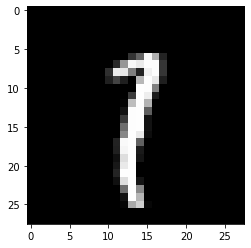

In [182]:
def check_errors(model, data_loader):
    num_correct = 0
    num_samples = 0
    model.eval()
    n = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x).argmax(1)
            incorrect = [i for i, x in enumerate(y != y_pred) if x]
            for i in incorrect:
                print(y[i], y_pred[i])
                plt.imshow(x[i][0], cmap='gray')
                n += 1
            if n >= 1:
                break
            
    

check_errors(model, test_loader)